<div style="width: 100%; height: 50px; background-color: #99EDC3"><h1 style="font-family: manrope; color: black; text-align: center; vertical-align: middle; line-height: 50px"><strong>PostPilot Challenge</strong></h1></div> </br>

<div style="color: black; font-family: sans-serif">
This is the PostPilot notebook containing templates and some analysis as required.
</br>

<h5> <strong>Data Visualization: </strong></h5>
Using the tools of your choice (whether in GCP or elsewhere), please create a few simple visualizations of the sandbox data set linked above:

-  <strong>Delivery times:</strong>: Visualize the time between the SHIPPED_AT date and the DELIVERED_AT for the top 10 countries with the most orders in the dataset;
-  <strong>Most-ordered products:</strong>: Visualize the most-ordered items by country for the top 10 countries with the most orders in the data set;
-  <strong>Average order value by browser:</strong> visualize the relationship between the browser someone uses and their average order value. Pay special attention to users who use multiple browsers - how would you visualize that? 

<div style="color: black; font-family: sans-serif">
<h5> <strong>Modeling and Machine learning:</strong></h5>

Context: We are doing a modeling project for Susan, who works at The Look Ecommerce, where she is responsible for Conversion Rate Optimization and Retention. She has hired you (Very Smart Data Scientist) to implement some basic models to help her out. 
Suppose Susan would like you to complete two modeling projects: one supporting conversion rate optimization (to be integrated into the site), and another to be run in a more static way to identify the best prospects for a direct mail retention campaign.
   
       
<h5><strong>Conversion rate optimization</strong></h5>

Susan has the ability to show certain visitors an exit popup, offering them a discount. However, she does not want to show the exit popup to all visitors, because some visitors would have converted anyway, and giving them a discount would hurt their margins.



The machine learning model that you're going to develop will tell Susan whether to show an exit popup for a specific visitor. The site will call an API with a single parameter (the SESSION_ID) which will kick off your model, which itself returns a single boolean (SHOW_POPUP). 



Using the website visit data (in the EVENTS table) and the ORDERS, USERS, and ORDER_ITEMS table, please create a simple machine learning model that would answer the question of whether to show a popup to a specific customer or not. Please describe all your steps (including any feature engineering that is necessary) and try to keep things simple. 



Please make the following (simplifying) assumptions:

Susan does not want to show the popup if the expected value of the customer (without being shown the popup) is at least $5. 

When the API call is made, the USER_ID from the EVENTS table is unknown in any case. The following columns from the EVENTS table are known:

- ID
- SESSION_ID
- CREATED_AT
- IP_ADDRESS
- CITY
- STATE
- POSTAL CODE
- BROWSER
- TRAFFIC_SOURCE
- URI
- EVENT_TYPE

Assume the site is built such that the API call is made exactly once for each visitor, so there's no need to think about any logic for properly handling redundant calls.

You can have the technical "entry point" for your model to be anything you like, it just needs to accept a SESSION_ID and return a true/false value for whether or not the site should show the exit popup.  (Some possibilities for how this could be implemented include a python script that runs from a CLI with a single parameter, a R method that accepts a parameter, or even a value placed in a where  clause in a SQL query. )

Please feel free to make any other simplifying assumptions that would make your life easier. 🙂  This is just an exercise, and we do not need you to spin your wheels on minor details. 
Once you've completed the model, please send over a small write-up of how we would access and/or run your model.  In addition, please describe the statistical strength of your model. Would you feel comfortable running this model in production, and why (or why not)? 


<h5> <strong>Retention</strong></h5>

Susan also wants to use her favorite direct mail marketing automation platform, PostPilot, to send postcards to customers to get them to come back and make another purchase. However, postcards are not cheap, and she'd rather not send postcard to customers who are unlikely to ever come back.
Build a simple machine learning model that scores all existing customers, and creates a probability score for each of them, with the probability that they'll come back within the next 180 days.
You can add as few or as many features to this model as you want. We just want to see how you think, and understand that you may not have time to add a whole bunch of features. If you think additional features may improve the strength of your model, feel free to mention the specific features you'd add (even if you didn't add them). 

<h5> <strong>Final Thoughts</strong></h5>

Feel free to reach out to us if you have any questions or need clarification on any point in the assignment.
Remember as well that you may not have enough time in 2-3 hours to complete these responses in depth - that's ok!  We want you to think critically about the most important aspects of each task, demonstrate an ability to understand and chart a solution to the problem, and implement as much of it as possible under the time constraints.
When we meet to discuss your submission, we'll have time to discuss any incomplete areas, and talk through how you might have completed the rest of the implementation and task given additional time, as well as the differences between these "toy" projects and something you would build for a large-scale production system powering a business like PostPilot.
Good luck!

</div>
<br>

In [25]:
# Importing libs

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 999)
pd.options.mode.chained_assignment = None

In [26]:
#libs and funcs

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import RobustScaler, LabelEncoder

warnings.filterwarnings("ignore")
def get_cols(df, target='SHOW_POPUP', cols2exc=[]):
    '''
    Separate features for normalization, encoding and target
    '''
    # features que passarão pelo enconding - objetos 
    cols2enc = [target] + [x for x in df.select_dtypes(include=['object']).columns if x not in cols2exc and x not in [target]]
    # features que serão normalizadas
    cols2norm = [x for x in df.select_dtypes(include=['int64', 'float64']).columns if x not in cols2exc and x not in cols2enc] 
        
    return cols2enc, cols2norm 

def encoding_only(df, cols2enc):
    """
    Encode categorical columns in a DataFrame using Label Encoding.
    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - cols2enc (list): List of column names to be label-encoded.
    Returns:
    Tuple[pd.DataFrame, dict]: A tuple containing the encoded DataFrame and a dictionary
                               of LabelEncoders used for each encoded column.

    This function performs Label Encoding on specified columns of the input DataFrame. 
    It returns a new DataFrame with the categorical columns encoded and a dictionary 
    of LabelEncoders for each encoded column.
    Example:
    ```
    encoded_df, encoders_dict = encoding_only(input_df, cols2enc=['Category', 'Color'])
    ```
    Note:
    - The input DataFrame 'df' is not modified in place; a new DataFrame is returned.
    - The 'cols2enc' parameter specifies which columns to label-encode.
    - The returned 'encoders' dictionary provides mapping from original values to encoded values.
    """
    
    from sklearn.preprocessing import LabelEncoder

    df_encoded = pd.DataFrame()
    
    encoders = dict()
    for col in cols2enc:
        encoder = LabelEncoder()
        encoded = encoder.fit_transform(df[col])
        df_encoded[col] = encoded
        encoders[col] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
        
    return df_encoded, encoders

def drop_columns_with_suffixes(df, suffixes=['_1', '_2']):
    """
    Remove columns from a DataFrame that have specified suffixes.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - suffixes (list, optional): List of suffixes to identify and drop from column names.
                                 Default is ['_1', '_2'].

    Returns:
    pd.DataFrame: DataFrame with columns having specified suffixes removed.

    This function identifies columns in the provided DataFrame with names ending with
    any of the specified suffixes and drops those columns. The modified DataFrame is
    then returned.
    Example:
    ```
    df = drop_columns_with_suffixes(input_df, suffixes=['_A', '_B'])
    ```
    Note:
    - The input DataFrame 'df' is not modified in place; a new DataFrame is returned.
    - The default suffixes are set to ['_1', '_2'], but you can customize them as needed.
    """
    # Find any column with suffixes
    columns_to_drop = [col for col in df.columns if any(col.endswith(suffix) for suffix in suffixes)]
    
    # Drop identified columns
    df = df.drop(columns=columns_to_drop)
    
    return df

def evaluate_model(model, X, y):
    """
    Evaluate the performance of a binary classification model.

    Parameters:
    - model (object): The trained binary classification model.
    - X (array-like or pd.DataFrame): Feature matrix for evaluation.
    - y (array-like or pd.Series): True labels for the provided features.
    Returns:
    None
    This function performs the following evaluations and displays the results:
    1. Receiver Operating Characteristic (ROC) Curve with Area Under the Curve (AUC) score.
    2. Confusion Matrix.
    3. Accuracy.
    4. F1 Score.
    5. Recall.
    The ROC curve is plotted, and the confusion matrix, accuracy, F1 score, and recall are printed.
    Example:
    ```
    evaluate_model(trained_model, X_test, y_test)
    ```
    Note:
    - This function requires the scikit-learn library for metrics computation.
    - The ROC curve is plotted using Matplotlib.
    """
    from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, recall_score
    from sklearn.metrics import confusion_matrix
    # Predict probabilities
    y_prob = model.predict_proba(X)[:, 1]

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Predict classes
    y_pred = model.predict(X)

    # Display confusion matrix
    conf_matrix = confusion_matrix(y, y_pred)
    print('Confusion Matrix:')
    print(conf_matrix)

    # Calculate and display accuracy, F1 score, and recall
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    recall = recall_score(y, y_pred)

    print('Accuracy: {:.2f}'.format(acc))
    print('F1 Score: {:.2f}'.format(f1))
    print('Recall: {:.2f}'.format(recall))




In [27]:
def check_cols(data, columns):
    """
    Generate a summary DataFrame for specified columns in a given DataFrame.

    Parameters:
    - data (pd.DataFrame): The input DataFrame to analyze.
    - columns (list): List of column names to check.

    Returns:
    pd.DataFrame: A DataFrame summarizing information about the specified columns,
                  including data types, the number of unique values, the count of NaN values,
                  and the percentage of NaN values relative to the total number of rows.
                  The DataFrame is sorted by the count of NaN values in ascending order.
    """
    df_check = pd.DataFrame(
        zip(
            data[columns].dtypes.index,
            data[columns].dtypes,
            data[columns].nunique(),
            data[columns].isna().sum(),
            round(data[columns].isna().sum() / data.shape[0], 3) * 100
        ),
        columns=['Variável', 'Tipo', 'Qtde_unicos', 'Qtde_NaN', '%_NaN']
    )
    return df_check.sort_values('Qtde_NaN').reset_index().drop('index', axis=1)


In [28]:
# Loading data
df_table= pd.read_csv(r"../files/table_full.csv", sep=',')

In [29]:
# checking unique values, nan and % of nan values ad type of the values.
check_cols(df_table, df_table.columns)

,Variável,Tipo,Qtde_unicos,Qtde_NaN,%_NaN
0,id,int64,12949,0,0.0
1,latitude,float64,6173,0,0.0
2,longitude,float64,6138,0,0.0
3,traffic_source_1,object,5,0,0.0
4,created_at_1,object,10035,0,0.0
5,order_id,int64,10598,0,0.0
6,user_id_1,int64,10068,0,0.0
7,status,object,5,0,0.0
8,gender_1,object,2,0,0.0
9,created_at_2,object,10464,0,0.0


In [30]:
df_table.head(6)

,id,user_id,sequence_number,session_id,created_at,ip_address,city,state,postal_code,browser,traffic_source,uri,event_type,id_1,first_name,last_name,email,age,gender,state_1,street_address,postal_code_1,city_1,country,latitude,longitude,traffic_source_1,created_at_1,order_id,user_id_1,status,gender_1,created_at_2,returned_at,shipped_at,delivered_at,num_of_item,id_2,order_id_1,user_id_2,product_id,inventory_item_id,status_1,created_at_3,shipped_at_1,delivered_at_1,returned_at_1,sale_price
0,914800,69704,4,4c7be2d7-dadd-4fb7-9c81-223f5cb48ddb,2023-11-24 08:52:59.000000 UTC,117.178.149.148,Sapporo,Hokkaido,002-8054,Firefox,Email,/cart,cart,69704,Nicholas,Ellis,nicholasellis@example.com,59,M,Hokkaido,7058 King Orchard Apt. 677,002-8054,Sapporo,Japan,43.157368,141.399137,Organic,2021-03-28 12:26:00.000000 UTC,87493,69704,Returned,M,2023-11-24 12:26:00.000000 UTC,2023-11-30 04:19:00.000000 UTC,2023-11-26 04:32:00.000000 UTC,2023-11-27 18:06:00.000000 UTC,1,127206,87493,69704,17839,343821,Returned,2023-11-24 08:56:04.000000 UTC,2023-11-26 04:32:00.000000 UTC,2023-11-27 18:06:00.000000 UTC,2023-11-30 04:19:00.000000 UTC,26.680000
1,941606,71802,12,21a78467-594b-4ce6-bc46-e39c0018926e,2022-06-15 12:03:16.000000 UTC,126.190.183.58,São Paulo,São Paulo,02675-031,Chrome,Adwords,/cart,cart,71802,Christopher,Curry,christophercurry@example.org,63,M,São Paulo,2487 Gregory Garden,02675-031,São Paulo,Brasil,-23.472562,-46.746566,Display,2021-06-01 13:40:00.000000 UTC,90095,71802,Shipped,M,2022-06-15 13:40:00.000000 UTC,NaN,2022-06-16 22:09:00.000000 UTC,NaN,4,130953,90095,71802,20819,353987,Shipped,2022-06-18 12:04:21.000000 UTC,2022-06-16 22:09:00.000000 UTC,NaN,NaN,31.990000
2,941606,71802,12,21a78467-594b-4ce6-bc46-e39c0018926e,2022-06-15 12:03:16.000000 UTC,126.190.183.58,São Paulo,São Paulo,02675-031,Chrome,Adwords,/cart,cart,71802,Christopher,Curry,christophercurry@example.org,63,M,São Paulo,2487 Gregory Garden,02675-031,São Paulo,Brasil,-23.472562,-46.746566,Display,2021-06-01 13:40:00.000000 UTC,90095,71802,Shipped,M,2022-06-15 13:40:00.000000 UTC,NaN,2022-06-16 22:09:00.000000 UTC,NaN,4,130952,90095,71802,24374,353984,Shipped,2022-06-17 11:26:21.000000 UTC,2022-06-16 22:09:00.000000 UTC,NaN,NaN,114.989998
3,761069,58014,3,cc78345f-3ded-4e36-bfd0-3396ec935a3c,2023-11-20 14:34:45.000000 UTC,214.53.255.153,São Paulo,São Paulo,02675-031,Chrome,YouTube,/cart,cart,58014,Carl,Phelps,carlphelps@example.net,23,M,São Paulo,7949 Thomas Greens Suite 636,02675-031,São Paulo,Brasil,-23.472562,-46.746566,Organic,2023-11-16 18:09:00.000000 UTC,72801,58014,Returned,M,2023-11-20 18:09:00.000000 UTC,2023-11-24 16:47:00.000000 UTC,2023-11-20 23:20:00.000000 UTC,2023-11-23 18:02:00.000000 UTC,2,105833,72801,58014,28254,286113,Returned,2023-11-21 14:40:11.000000 UTC,2023-11-20 23:20:00.000000 UTC,2023-11-23 18:02:00.000000 UTC,2023-11-24 16:47:00.000000 UTC,69.500000
4,589416,44848,6,36a06839-f0c3-4471-8914-d9d1703b1d54,2022-03-05 00:26:14.000000 UTC,55.51.97.116,São Paulo,São Paulo,02675-031,Chrome,YouTube,/cart,cart,44848,Eric,Lee,ericlee@example.com,61,M,São Paulo,17429 Avila Loop,02675-031,São Paulo,Brasil,-23.472562,-46.746566,Search,2020-06-29 01:13:00.000000 UTC,56415,44848,Complete,M,2022-03-05 01:13:00.000000 UTC,NaN,2022-03-05 17:13:00.000000 UTC,2022-03-10 11:47:00.000000 UTC,4,82000,56415,44848,19312,221750,Complete,2022-03-08 00:38:41.000000 UTC,2022-03-05 17:13:00.000000 UTC,2022-03-10 11:47:00.000000 UTC,NaN,33.990002
5,589416,44848,6,36a06839-f0c3-4471-8914-d9d1703b1d54,2022-03-05 00:26:14.000000 UTC,55.51.97.116,São Paulo,São Paulo,02675-031,Chrome,YouTube,/cart,cart,44848,Eric,Lee,ericlee@example.com,61,M,São Paulo,17429 Avila Loop,02675-031,São Paulo,Brasil,-23.472562,-46.746566,Search,2020-06-29 01:13:00.000000 UTC,56415,44848,Complete,M,2022-03-05 01:13:00.000000 UTC,NaN,2022-03-05 17:13:00.000000 UTC,2022-03-10 11:47:00.000000 UTC,4,82001,56415,44848,24054,221754,Complete,2022-03-06 00:36:37.000000 UTC,2022-03-05 17:13:00.000000 UTC,2022

In [31]:
# considering the suffix _1 - users _2 - orders _3 - order_items
colunas_data = [
    'created_at', 'created_at_1', 'created_at_2',
    'returned_at', 'shipped_at', 'delivered_at',
    'created_at_3', 'shipped_at_1', 'delivered_at_1', 'returned_at_1'
]

# Iterating over the columns and converting to the desired format
for coluna in colunas_data:
    df_table[coluna] = pd.to_datetime(df_table[coluna], format='%Y-%m-%d %H:%M:%S.%f UTC', errors='coerce')

print(df_table)

           id  user_id  sequence_number                            session_id  \
0      914800    69704                4  4c7be2d7-dadd-4fb7-9c81-223f5cb48ddb   
1      941606    71802               12  21a78467-594b-4ce6-bc46-e39c0018926e   
2      941606    71802               12  21a78467-594b-4ce6-bc46-e39c0018926e   
3      761069    58014                3  cc78345f-3ded-4e36-bfd0-3396ec935a3c   
4      589416    44848                6  36a06839-f0c3-4471-8914-d9d1703b1d54   
...       ...      ...              ...                                   ...   
14281  614005    46755                6  940b387c-a8ce-43b8-928a-e025cad947df   
14282  614005    46755                6  940b387c-a8ce-43b8-928a-e025cad947df   
14283  835252    63748                6  d5bc5725-40e6-4951-b236-ce74d1a15abc   
14284  678311    51795                9  85158612-cc15-4eb8-9309-e6f27e9d857b   
14285  141099    10674                9  436c956f-3ada-4741-bcbe-cec4337046ab   

               created_at  

In [32]:
#chekcing again after first treatment
check_cols(df_table, df_table.columns)

,Variável,Tipo,Qtde_unicos,Qtde_NaN,%_NaN
0,id,int64,12949,0,0.0
1,latitude,float64,6173,0,0.0
2,longitude,float64,6138,0,0.0
3,traffic_source_1,object,5,0,0.0
4,created_at_1,datetime64[ns],10035,0,0.0
5,order_id,int64,10598,0,0.0
6,user_id_1,int64,10068,0,0.0
7,status,object,5,0,0.0
8,gender_1,object,2,0,0.0
9,created_at_2,datetime64[ns],10464,0,0.0


In [33]:
# first look at the data at what becomes the target - values greater than 5 dollars in sales_price
df_table.query("sale_price > 5")

,id,user_id,sequence_number,session_id,created_at,ip_address,city,state,postal_code,browser,traffic_source,uri,event_type,id_1,first_name,last_name,email,age,gender,state_1,street_address,postal_code_1,city_1,country,latitude,longitude,traffic_source_1,created_at_1,order_id,user_id_1,status,gender_1,created_at_2,returned_at,shipped_at,delivered_at,num_of_item,id_2,order_id_1,user_id_2,product_id,inventory_item_id,status_1,created_at_3,shipped_at_1,delivered_at_1,returned_at_1,sale_price
0,914800,69704,4,4c7be2d7-dadd-4fb7-9c81-223f5cb48ddb,2023-11-24 08:52:59,117.178.149.148,Sapporo,Hokkaido,002-8054,Firefox,Email,/cart,cart,69704,Nicholas,Ellis,nicholasellis@example.com,59,M,Hokkaido,7058 King Orchard Apt. 677,002-8054,Sapporo,Japan,43.157368,141.399137,Organic,2021-03-28 12:26:00,87493,69704,Returned,M,2023-11-24 12:26:00,2023-11-30 04:19:00,2023-11-26 04:32:00,2023-11-27 18:06:00,1,127206,87493,69704,17839,343821,Returned,2023-11-24 08:56:04,2023-11-26 04:32:00,2023-11-27 18:06:00,2023-11-30 04:19:00,26.680000
1,941606,71802,12,21a78467-594b-4ce6-bc46-e39c0018926e,2022-06-15 12:03:16,126.190.183.58,São Paulo,São Paulo,02675-031,Chrome,Adwords,/cart,cart,71802,Christopher,Curry,christophercurry@example.org,63,M,São Paulo,2487 Gregory Garden,02675-031,São Paulo,Brasil,-23.472562,-46.746566,Display,2021-06-01 13:40:00,90095,71802,Shipped,M,2022-06-15 13:40:00,NaT,2022-06-16 22:09:00,NaT,4,130953,90095,71802,20819,353987,Shipped,2022-06-18 12:04:21,2022-06-16 22:09:00,NaT,NaT,31.990000
2,941606,71802,12,21a78467-594b-4ce6-bc46-e39c0018926e,2022-06-15 12:03:16,126.190.183.58,São Paulo,São Paulo,02675-031,Chrome,Adwords,/cart,cart,71802,Christopher,Curry,christophercurry@example.org,63,M,São Paulo,2487 Gregory Garden,02675-031,São Paulo,Brasil,-23.472562,-46.746566,Display,2021-06-01 13:40:00,90095,71802,Shipped,M,2022-06-15 13:40:00,NaT,2022-06-16 22:09:00,NaT,4,130952,90095,71802,24374,353984,Shipped,2022-06-17 11:26:21,2022-06-16 22:09:00,NaT,NaT,114.989998
3,761069,58014,3,cc78345f-3ded-4e36-bfd0-3396ec935a3c,2023-11-20 14:34:45,214.53.255.153,São Paulo,São Paulo,02675-031,Chrome,YouTube,/cart,cart,58014,Carl,Phelps,carlphelps@example.net,23,M,São Paulo,7949 Thomas Greens Suite 636,02675-031,São Paulo,Brasil,-23.472562,-46.746566,Organic,2023-11-16 18:09:00,72801,58014,Returned,M,2023-11-20 18:09:00,2023-11-24 16:47:00,2023-11-20 23:20:00,2023-11-23 18:02:00,2,105833,72801,58014,28254,286113,Returned,2023-11-21 14:40:11,2023-11-20 23:20:00,2023-11-23 18:02:00,2023-11-24 16:47:00,69.500000
4,589416,44848,6,36a06839-f0c3-4471-8914-d9d1703b1d54,2022-03-05 00:26:14,55.51.97.116,São Paulo,São Paulo,02675-031,Chrome,YouTube,/cart,cart,44848,Eric,Lee,ericlee@example.com,61,M,São Paulo,17429 Avila Loop,02675-031,São Paulo,Brasil,-23.472562,-46.746566,Search,2020-06-29 01:13:00,56415,44848,Complete,M,2022-03-05 01:13:00,NaT,2022-03-05 17:13:00,2022-03-10 11:47:00,4,82000,56415,44848,19312,221750,Complete,2022-03-08 00:38:41,2022-03-05 17:13:00,2022-03-10 11:47:00,NaT,33.990002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14281,614005,46755,6,940b387c-a8ce-43b8-928a-e025cad947df,2022-08-20 13:07:26,209.23.35.158,Glen Allen,Virginia,23059,Safari,Organic,/cart,cart,46755,Allen,Paul,allenpaul@example.net,38,M,Virginia,5542 Mary Parks,23059,Glen Allen,United States,37.700903,-77.564737,Search,2019-05-11 13:17:00,58785,46755,Processing,M,2022-08-20 13:17:00,NaT,NaT,NaT,3,85427,58785,46755,16381,231025,Processing,2022-08-24 13:12:32,NaT,NaT,NaT,21.450001
14282,614005,46755,6,940b387c-a8ce-43b8-928a-e025cad947df,2022-08-20 13:07:26,209.23.35.158,Glen Allen,Virginia,23059,Safari,Organic,/cart,cart,46755,Allen,Paul,allenpaul@example.net,38,M,Virginia,5542 Mary Parks,23059,Glen Allen,United States,37.700903,-77.564737,Search,2019-05-11 13:17:00,58785,46755,Processing,M,2022-08-20 13:17:00,NaT,NaT,

In [34]:
# Creating some feature engineering
df_table['total_purchase_value'] = df_table.groupby('user_id')['sale_price'].transform('sum')
df_table['visit_count'] = df_table.groupby('user_id')['session_id'].transform('count')

1. Conversion rate optimization

In [35]:
# Creating my target - I decided to create a variable that added the values linked to purchases 
# by users to see if the number of lines with this information increased.
df_table['SHOW_POPUP'] = (df_table['total_purchase_value'] < 5).astype(int)

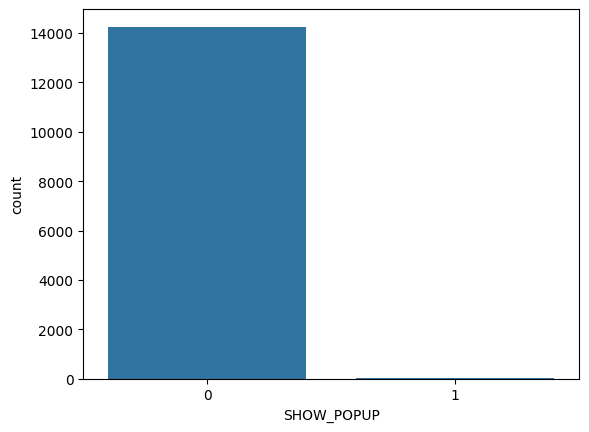

In [36]:
# first look at our classes
sns.countplot(x='SHOW_POPUP', data=df_table)
plt.show()
# This is really bad for designing a machine learning model. 
# The class is simply absolutely unbalanced, with almost no data to train a model.

In [37]:
# renaming some columns with different information. These columns are coming from the creation of some data so i decided to keep to analyze.
df_table.rename(columns = {'created_at_1': 'created_at1', 'created_at_2': 'created_at2', 'created_at_3': 'created_at3'})

,id,user_id,sequence_number,session_id,created_at,ip_address,city,state,postal_code,browser,traffic_source,uri,event_type,id_1,first_name,last_name,email,age,gender,state_1,street_address,postal_code_1,city_1,country,latitude,longitude,traffic_source_1,created_at1,order_id,user_id_1,status,gender_1,created_at2,returned_at,shipped_at,delivered_at,num_of_item,id_2,order_id_1,user_id_2,product_id,inventory_item_id,status_1,created_at3,shipped_at_1,delivered_at_1,returned_at_1,sale_price,total_purchase_value,visit_count,SHOW_POPUP
0,914800,69704,4,4c7be2d7-dadd-4fb7-9c81-223f5cb48ddb,2023-11-24 08:52:59,117.178.149.148,Sapporo,Hokkaido,002-8054,Firefox,Email,/cart,cart,69704,Nicholas,Ellis,nicholasellis@example.com,59,M,Hokkaido,7058 King Orchard Apt. 677,002-8054,Sapporo,Japan,43.157368,141.399137,Organic,2021-03-28 12:26:00,87493,69704,Returned,M,2023-11-24 12:26:00,2023-11-30 04:19:00,2023-11-26 04:32:00,2023-11-27 18:06:00,1,127206,87493,69704,17839,343821,Returned,2023-11-24 08:56:04,2023-11-26 04:32:00,2023-11-27 18:06:00,2023-11-30 04:19:00,26.680000,26.680000,1,0
1,941606,71802,12,21a78467-594b-4ce6-bc46-e39c0018926e,2022-06-15 12:03:16,126.190.183.58,São Paulo,São Paulo,02675-031,Chrome,Adwords,/cart,cart,71802,Christopher,Curry,christophercurry@example.org,63,M,São Paulo,2487 Gregory Garden,02675-031,São Paulo,Brasil,-23.472562,-46.746566,Display,2021-06-01 13:40:00,90095,71802,Shipped,M,2022-06-15 13:40:00,NaT,2022-06-16 22:09:00,NaT,4,130953,90095,71802,20819,353987,Shipped,2022-06-18 12:04:21,2022-06-16 22:09:00,NaT,NaT,31.990000,178.969997,3,0
2,941606,71802,12,21a78467-594b-4ce6-bc46-e39c0018926e,2022-06-15 12:03:16,126.190.183.58,São Paulo,São Paulo,02675-031,Chrome,Adwords,/cart,cart,71802,Christopher,Curry,christophercurry@example.org,63,M,São Paulo,2487 Gregory Garden,02675-031,São Paulo,Brasil,-23.472562,-46.746566,Display,2021-06-01 13:40:00,90095,71802,Shipped,M,2022-06-15 13:40:00,NaT,2022-06-16 22:09:00,NaT,4,130952,90095,71802,24374,353984,Shipped,2022-06-17 11:26:21,2022-06-16 22:09:00,NaT,NaT,114.989998,178.969997,3,0
3,761069,58014,3,cc78345f-3ded-4e36-bfd0-3396ec935a3c,2023-11-20 14:34:45,214.53.255.153,São Paulo,São Paulo,02675-031,Chrome,YouTube,/cart,cart,58014,Carl,Phelps,carlphelps@example.net,23,M,São Paulo,7949 Thomas Greens Suite 636,02675-031,São Paulo,Brasil,-23.472562,-46.746566,Organic,2023-11-16 18:09:00,72801,58014,Returned,M,2023-11-20 18:09:00,2023-11-24 16:47:00,2023-11-20 23:20:00,2023-11-23 18:02:00,2,105833,72801,58014,28254,286113,Returned,2023-11-21 14:40:11,2023-11-20 23:20:00,2023-11-23 18:02:00,2023-11-24 16:47:00,69.500000,69.500000,1,0
4,589416,44848,6,36a06839-f0c3-4471-8914-d9d1703b1d54,2022-03-05 00:26:14,55.51.97.116,São Paulo,São Paulo,02675-031,Chrome,YouTube,/cart,cart,44848,Eric,Lee,ericlee@example.com,61,M,São Paulo,17429 Avila Loop,02675-031,São Paulo,Brasil,-23.472562,-46.746566,Search,2020-06-29 01:13:00,56415,44848,Complete,M,2022-03-05 01:13:00,NaT,2022-03-05 17:13:00,2022-03-10 11:47:00,4,82000,56415,44848,19312,221750,Complete,2022-03-08 00:38:41,2022-03-05 17:13:00,2022-03-10 11:47:00,NaT,33.990002,172.550007,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14281,614005,46755,6,940b387c-a8ce-43b8-928a-e025cad947df,2022-08-20 13:07:26,209.23.35.158,Glen Allen,Virginia,23059,Safari,Organic,/cart,cart,46755,Allen,Paul,allenpaul@example.net,38,M,Virginia,5542 Mary Parks,23059,Glen Allen,United States,37.700903,-77.564737,Search,2019-05-11 13:17:00,58785,46755,Processing,M,2022-08-20 13:17:00,NaT,NaT,NaT,3,85427,58785,46755,16381,231025,Processing,2022-08-24 13:12:32,NaT,NaT,NaT,21.450001,79.400002,3,0
14282,614005,46755,6,940b387c-a8ce-43b8-928a-e025cad947df,2022-08-20 13:07:26,209.23.35.158,Glen Allen,Virginia,23059,Safari,Organic,/cart,cart,46755,Allen,Paul,allenpaul@example.net,38,M,Virginia,5542 Mar

In [38]:
# After analyzing the columns that have repetition suffixes (which came from the tables that were joined here), I decided to exclude 
# the redundant columns, leaving only one that contains the information - repeated - in these columns.
df_table = drop_columns_with_suffixes(df_table, suffixes=['_1', '_2']).copy()

In [39]:
# checking data
df_table['event_type'].value_counts()

event_type
cart          4954
department    4124
product       3952
purchase       845
home           411
Name: count, dtype: int64

In [40]:
# encoding columns to use in the model
cols_to_encode = ['city', 'state', 'postal_code', 'browser', 'traffic_source', 'event_type', 'gender', 
                  'country', 'status', 'visit_count', 'product_id']  
df_enconded, encoders = encoding_only(df_table, cols_to_encode)

##### It is important to point out that here, despite the instruction to keep the model as simple as possible, I tested a catboost to see if the selection of features (which was a limited set) would be different from what is laid out here and after several attempts with different combinations, there was no increase. I consider a feature selector as something that brings more robustness to the model. I usually test at least two, but in this case I tested the one I most often use to check whether there would be an increase in quality or not, even though I know that with the model's classes, as they are, they will not be saved.

In [41]:
# Well, lets work. Split train_test, 80/20... 
df = df_table
selected_features = ['city', 'state', 'postal_code', 'browser', 'traffic_source', 'event_type', 'gender', 
                  'country', 'status', 'visit_count', 'product_id'] 
X = df_enconded[selected_features]
y = df['SHOW_POPUP']



In [42]:
# train test split
X = df_enconded[selected_features]
y = df['SHOW_POPUP']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Eval Model
y_pred = model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

Accuracy: 0.996850944716585
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2849
           1       0.00      0.00      0.00         9

    accuracy                           1.00      2858
   macro avg       0.50      0.50      0.50      2858
weighted avg       0.99      1.00      1.00      2858



##### As I expected, the model is terrible. The fully rounded metrics bring the certainty that overfitting is screaming at the base. With the serious imbalance of the classes, this was the obvious end. What would I try in this case here? Well, firstly I could try to create synthetic data using SMOTE (Synthetic Minority Over-sampling Technique) to try to make the model generate some results. Other measures such as resampling, class weighing, adjusting the decision threshold, Stratified Cross Validation, etc., would require a little more data in the minority class.


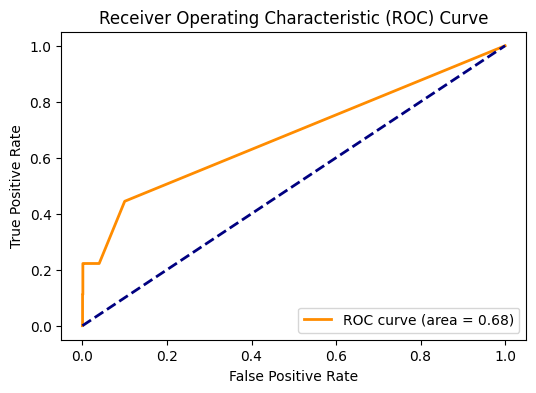

Confusion Matrix:
[[2849    0]
 [   9    0]]
Accuracy: 1.00
F1 Score: 0.00
Recall: 0.00


In [43]:
evaluate_model(model, X_test, y_test)

True Positives (TP): 0 </br>
True Negatives (TN): 2849 </br>
False Positives (FP): 0 </br>
False Negatives (FN): 9 </br>

##### As we can see, metrics practically do not exist. Accuracy at 100 while other metrics are at 0. As we know, accuracy greatly impacts the roc curve. The curve being moderate means nothing without analyzing the entire context. The confusion matrix also sets the tone for the result > an epic failure.

In [44]:
class_validation = pd.DataFrame(pd.DataFrame(y_train).value_counts(normalize = True).mul(100).round(2))

print(class_validation)

# unbelievably unbalanced classes

            proportion
SHOW_POPUP            
0                99.78
1                 0.22


2. Retention

In [45]:
#Cresting Target
df_table['Return'] = (df_table['delivered_at'] >= (df_table['delivered_at'].max() - pd.Timedelta(days=180))).astype(int)

In [48]:
# Checking results
df_table[['delivered_at', 'Return']].sample(10)

# 0 

,delivered_at,Return
12412,NaT,0
10037,NaT,0
5007,NaT,0
10468,NaT,0
10533,2021-10-30 22:22:00.000000,0
10587,2023-12-13 05:25:07.960355,1
4429,NaT,0
6976,2023-11-08 10:52:00.000000,1
12701,NaT,0
8463,NaT,0


##### 0 for dates greater than 180 days and 1 for dates less than 180 days of visit, which would be our target for this model. Define who the customers would be most likely to return soon so that Susan can target her customer retention efforts.

In [187]:
#encoding columns
cols_to_encode_2 = ['city', 'state', 'postal_code', 'browser', 'traffic_source', 'age','event_type', 'gender', 
                  'country', 'status', 'visit_count', 'product_id', 'num_of_item']  
df_enconded_2, encoders_2 = encoding_only(df_table, cols_to_encode_2)

In [188]:
# split data
X_retorno = df_enconded_2
y_retorno = df_table['Return']

X_train_retorno, X_test_retorno, y_train_retorno, y_test_retorno = train_test_split(X_retorno, y_retorno, test_size=0.2, random_state=42)


In [189]:
# fit
model_retorno = RandomForestClassifier()
model_retorno.fit(X_train_retorno, y_train_retorno)

RandomForestClassifier()

In [190]:
y_pred_retorno = model_retorno.predict(X_test_retorno)

print(f'Accuracy: {accuracy_score(y_test_retorno, y_pred_retorno)}')
print(classification_report(y_test_retorno, y_pred_retorno))


Accuracy: 0.9058782365290413
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2502
           1       0.85      0.29      0.44       356

    accuracy                           0.91      2858
   macro avg       0.88      0.64      0.69      2858
weighted avg       0.90      0.91      0.89      2858



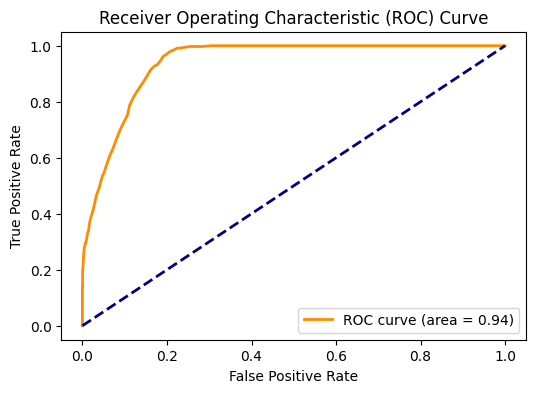

Confusion Matrix:
[[2484   18]
 [ 251  105]]
Accuracy: 0.91
F1 Score: 0.44
Recall: 0.29


In [191]:
evaluate_model(model_retorno, X_test_retorno, y_test_retorno)

In [193]:
class_validation_retorno = pd.DataFrame(pd.DataFrame(y_train_retorno).value_counts(normalize = True).mul(100).round(2))

print(class_validation_retorno)

# unbalanced classes

        proportion
Return            
0            87.53
1            12.47


Analyzing the classes and results of this model, it can be said that this one would have more salvation than the first. In this case, resampling techniques, creation of synthetic data, weights for classes, etc., could work better. The model in this case is not good because as a business matter, we manage to capture more false negatives than true positives. This means that Susan, if she followed the model like she does today, would lose more money sending postcards to the wrong users than she would improve her conversion rate. Knowing that conversion rates are naturally low, this would be a terrible path for marketing to follow.

Verdadeiros Positivos (TP): 105 </br>
Verdadeiros Negativos (TN): 2484 </br>
Falsos Positivos (FP): 18 </br>
Falsos Negativos (FN): 251 </br>

The biggest lesson I take from this takehome is what I already consider the most important > good exploratory data analysis is essential so that the model can be produced correctly. In the case of the first model, for example, it could be the case that we work with other business rules, redesign a target that is more suitable for the possibilities, etc. In the case of the second, you could apply other techniques before redefining the target, if it were really necessary.
Ps. For the latter, there was no time to design the probability or calibrate the result.

Thats all folks.